In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        #we could define exp and div functions and use them
        #but we don't need to -- we can use higher abstractions
        #all we need is to be able to compute the operator
        #and its derivative
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def total_backpropagate(self):
        #around 1:17:00 in the tutorial, Andrej asks something
        #like, "how do we automate this?" so I wrote this function
        #however, this is not the function he shows, because
        #this function would have to update *every node* every
        #time you update any node,
        #so instead he shows a version using topological sort
        #to find and update only the nodes that a given node's
        #derivative depends on, and only update that dependency
        #chain
        self._backward()
        for child in self._prev:
            child.total_backpropagate()
    
    #NEVERMIND WHAT I WROTE IN TOTAL_BACKPROPAGATE
    #APPARENTLY WE'RE JUST USING THIS FUNCTION ON THE WHOLE 
    #FUNCTION I GUESS... LOL
    #SO, WHAT'S EVEN THE DIFFERENCE WITH THIS AND SIMPLE RECURSION?
    #MAYBE IN MORE "INDUSTRIAL" VERSIONS THIS ALGORITHM
    #BECOMES IMPORTANT... ???
    def backward(self):
        # topological sort
        # lays out nodes so that all edges go only in one direction
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) #maintains invariant, since v is only
                               #appended AFTER all of its children
        build_topo(self)
         #for some reason my nodes are in a different order, but I'm 99% sure they're still in a "topologically-sorted" order...
         # why? idk...

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [3]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [4]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b') #magic constant so numbers come out nice
# SUM(x_i*w_i) + b
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [5]:
o.backward()

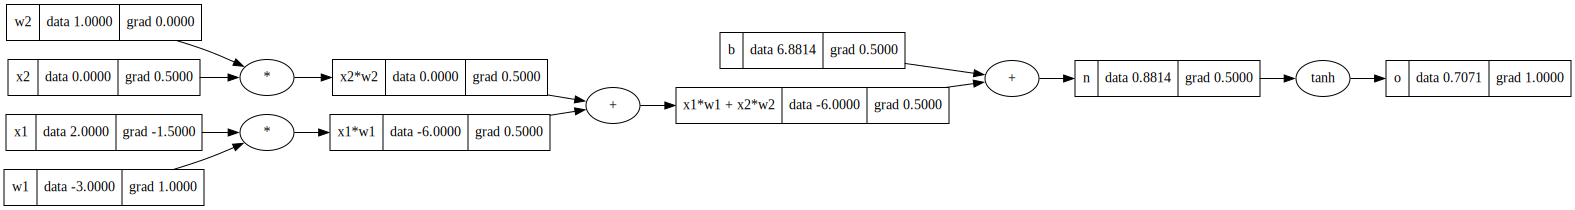

In [6]:
draw_dot(o)